# Segmentation example
This segmentation example shows a workflow to develop a model,
and use base + mask images of boundaries to train an AI to detect the boundaries.

The model results are terrible, as we will be developing the actual model during our construciton phase,
but this provides a valid technical demonstrator of the overall process.

In [67]:
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import tensorflow as tf
import cv2 as cv

from tensorflow.keras.layers import Input, Conv2D, Dropout, Activation, UpSampling2D, GlobalMaxPooling2D, multiply
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.merge import concatenate
from IPython.display import Image, clear_output

input_dir = "images/base"
target_dir = "images/masks"
img_size = (128, 128)
BATCH_SIZE =32


#we create two instances with the same arguments
data_gen_args = dict(vertical_flip=True,
                     horizontal_flip=True,
                    validation_split=0.2)

image_datagen = ImageDataGenerator(**data_gen_args, rescale=1.0/255.0)
mask_datagen = ImageDataGenerator(**data_gen_args, rescale=1.0/255.0)

# Provide the same seed and keyword arguments to the fit and flow methods
bs = 1
seed = 1
image_gen_train = image_datagen.flow_from_directory(input_dir, class_mode=None, target_size=img_size, seed=seed, batch_size=bs, subset="training")
mask_gen_train = mask_datagen.flow_from_directory(target_dir, class_mode="categorical", target_size=img_size, seed=seed, batch_size=bs, subset="training", color_mode='grayscale')

image_gen_val = image_datagen.flow_from_directory(input_dir, class_mode=None, target_size=img_size, seed=seed, batch_size=bs, subset="validation")
mask_gen_val = mask_datagen.flow_from_directory(target_dir, class_mode="categorical", target_size=img_size, seed=seed, batch_size=bs, subset="validation", color_mode='grayscale')

#normalize the masks
def normalize(img_batch):
    for(x) in img_batch:
        #y = np.expand_dims(x, 2)
        y = x[0]-1
        yield x[0]
        
def adjImage(img_batch, alpha, beta):
    for(x) in img_batch:
        yield x

def combine_generator(gen1, gen2):
    myGen = zip(gen1, normalize(gen2))
    for(g1, g2) in myGen:
        yield (g1, g2)

train_gen = combine_generator(image_gen_train, mask_gen_train)
val_gen = combine_generator(image_gen_val, mask_gen_val)

Found 363 images belonging to 1 classes.
Found 363 images belonging to 1 classes.
Found 90 images belonging to 1 classes.
Found 90 images belonging to 1 classes.


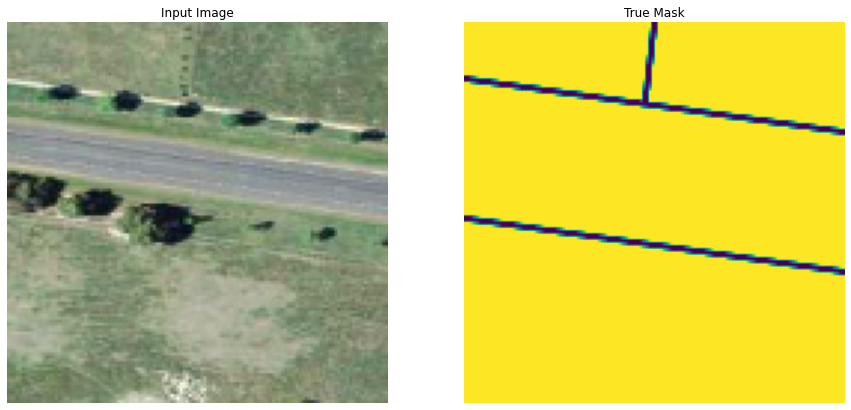

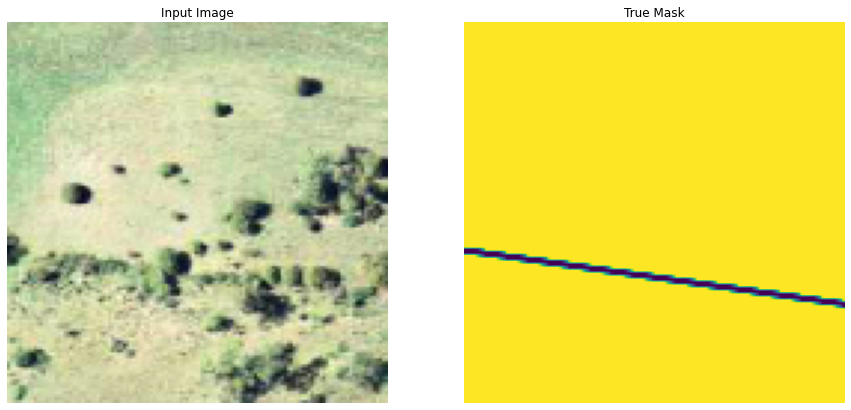

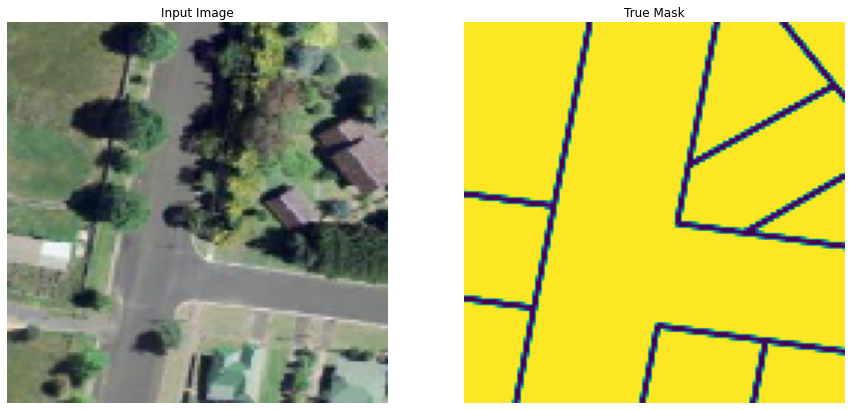

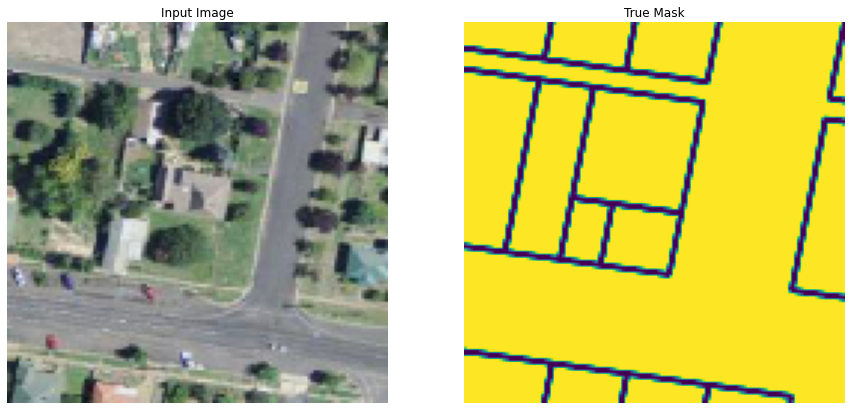

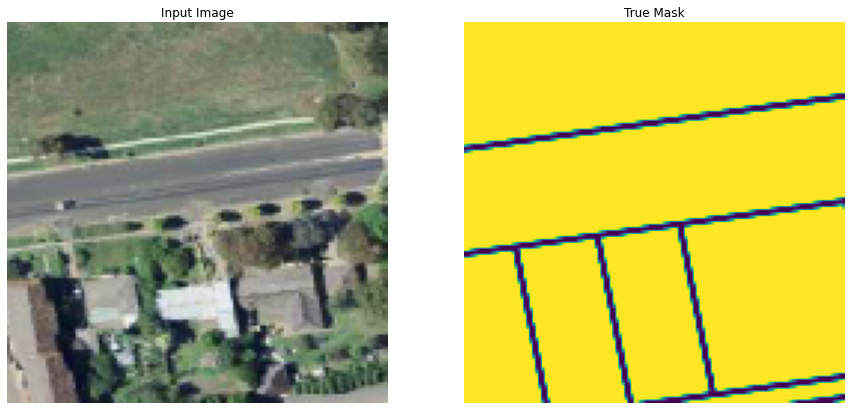

In [68]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for i in range(5):
    img, mask = next(train_gen)
    sample_image = img[0]
    sample_mask = mask[0]
    display([sample_image, sample_mask])

## Setup the model
From https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/segmentation_unet-three-plus_oxford-iiit.ipynb

In [69]:
from keras_unet_collection import models, base, utils
from tensorflow.keras.backend import max

name = 'unet3plus'
activation = 'ReLU'
filter_num_down = [32, 64, 128, 256, 512]
filter_num_skip = [32, 32, 32, 32]
filter_num_aggregate = 160

stack_num_down = 2
stack_num_up = 1
n_labels = 2

# `unet_3plus_2d_base` accepts an input tensor 
# and produces output tensors from different upsampling levels
# ---------------------------------------- #
input_tensor = keras.layers.Input((128, 128, 3))
# base architecture
X_decoder = base.unet_3plus_2d_base(
    input_tensor, filter_num_down, filter_num_skip, filter_num_aggregate, 
    stack_num_down=stack_num_down, stack_num_up=stack_num_up, activation=activation, 
    batch_norm=True, pool=True, unpool=True, backbone=None, name=name)

# allocating deep supervision tensors
OUT_stack = []
# reverse indexing `X_decoder`, so smaller tensors have larger list indices 
X_decoder = X_decoder[::-1]

# deep supervision outputs
for i in range(1, len(X_decoder)):
    # 3-by-3 conv2d --> upsampling --> sigmoid output activation
    pool_size = 2**(i)
    X = Conv2D(n_labels, 3, padding='same', name='{}_output_conv1_{}'.format(name, i-1))(X_decoder[i])
    
    X = UpSampling2D((pool_size, pool_size), interpolation='bilinear', 
                     name='{}_output_sup{}'.format(name, i-1))(X)
    
    X = Activation('sigmoid', name='{}_output_sup{}_activation'.format(name, i-1))(X)
    # collecting deep supervision tensors
    OUT_stack.append(X)

# the final output (without extra upsampling)
# 3-by-3 conv2d --> sigmoid output activation
X = Conv2D(n_labels, 3, padding='same', name='{}_output_final'.format(name))(X_decoder[0])
X = Activation('sigmoid', name='{}_output_final_activation'.format(name))(X)
# collecting final output tensors
OUT_stack.append(X)

# Classification-guided Module (CGM)
# ---------------------------------------- #
# dropout --> 1-by-1 conv2d --> global-maxpooling --> sigmoid
X_CGM = X_decoder[-1]
X_CGM = Dropout(rate=0.1)(X_CGM)
X_CGM = Conv2D(filter_num_skip[-1], 1, padding='same')(X_CGM)
X_CGM = GlobalMaxPooling2D()(X_CGM)
X_CGM = Activation('sigmoid')(X_CGM)

CGM_mask = max(X_CGM, axis=-1) # <----- This value could be trained with "none-organ image"

for i in range(len(OUT_stack)):
    if i < len(OUT_stack)-1:
        # deep-supervision
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_sup{}_CGM'.format(name, i))
    else:
        # final output
        OUT_stack[i] = multiply([OUT_stack[i], CGM_mask], name='{}_output_final_CGM'.format(name))
        
# executing all the above cells in one time to avoid dupilcated tensor names.
model = keras.models.Model([input_tensor,], OUT_stack)

## Compile the model

In [70]:
from tensorflow import keras

opt = keras.optimizers.Adam(1e-4)
model.compile(optimizer=opt,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

## Show functions
These functions allow the images to be displayed
We also show the predictions before the model is trained

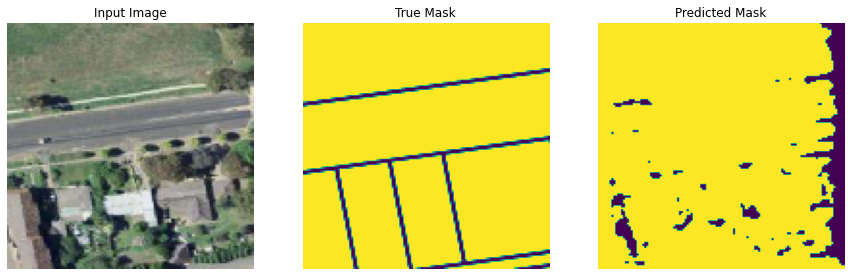

In [71]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(gen=None, num=1):
    if gen:
        for idx, (image_gen, mask_gen) in enumerate(gen):
            image = image_gen[0]
            mask = mask_gen[0]
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
            if(idx >= num):
                break
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...])[0])])
        
show_predictions()

## Define callbacks
These callbacks are run after each epoch
They show the current prediction result and save the model

In [72]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model4.h5', save_best_only=True),
    DisplayCallback()
]

# Train the model

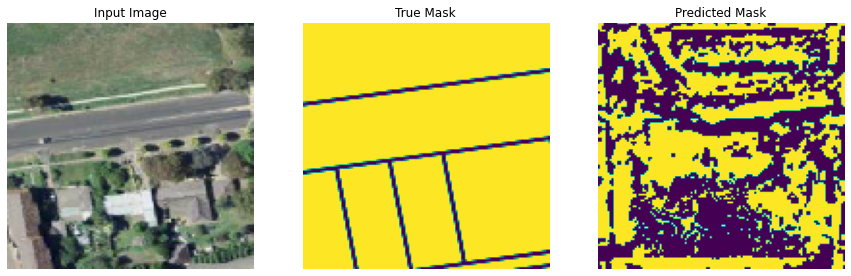


Sample Prediction after epoch 1926

32/32 [==============================] - 1s 46ms/step - loss: 6.5980 - unet3plus_output_sup0_CGM_loss: 1.3196 - unet3plus_output_sup1_CGM_loss: 1.3196 - unet3plus_output_sup2_CGM_loss: 1.3196 - unet3plus_output_sup3_CGM_loss: 1.3196 - unet3plus_output_final_CGM_loss: 1.3196 - unet3plus_output_sup0_CGM_accuracy: 0.5019 - unet3plus_output_sup1_CGM_accuracy: 0.4933 - unet3plus_output_sup2_CGM_accuracy: 0.4957 - unet3plus_output_sup3_CGM_accuracy: 0.4859 - unet3plus_output_final_CGM_accuracy: 0.4737 - val_loss: 6.6395 - val_unet3plus_output_sup0_CGM_loss: 1.3279 - val_unet3plus_output_sup1_CGM_loss: 1.3279 - val_unet3plus_output_sup2_CGM_loss: 1.3279 - val_unet3plus_output_sup3_CGM_loss: 1.3279 - val_unet3plus_output_final_CGM_loss: 1.3279 - val_unet3plus_output_sup0_CGM_accuracy: 0.4631 - val_unet3plus_output_sup1_CGM_accuracy: 0.4786 - val_unet3plus_output_sup2_CGM_accuracy: 0.4186 - val_unet3plus_output_sup3_CGM_accuracy: 0.4554 - val_unet3plus_outpu

KeyboardInterrupt: 

In [73]:
EPOCHS = 15000

model_history = model.fit(train_gen,
                          epochs=EPOCHS,
                          steps_per_epoch=BATCH_SIZE,
                          validation_data=val_gen,
                          validation_steps=BATCH_SIZE,
                          callbacks=callbacks)

In [63]:
## Show some predictions using our trained model

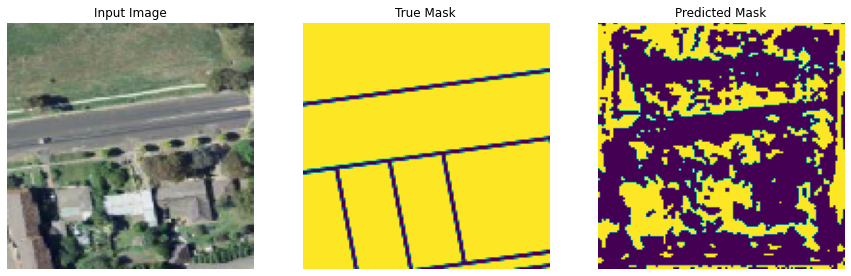

In [64]:
show_predictions()

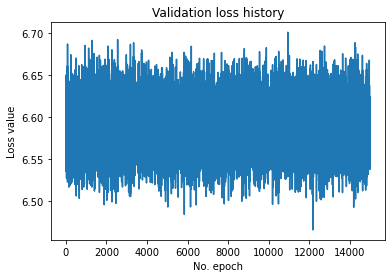

In [66]:
# Visualize history
# Plot history: Loss
plt.plot(model_history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()